#Introduction and Problem Statement
Diabetic Retinopathy (DR) is a leading cause of blindness among diabetic patients. Early detection and classification of DR severity can help in better treatment planning and patient monitoring. This project focuses on Unsupervised Learning techniques to analyze patient data to identify hidden patterns using clustering and dimensionality reduction.



#Data
The dataset I am using is the Brazilian Multilabel Ophthalmological Dataset (BRSET).

This dataset enables computer vision models to predict demographic characteristics and multi-label disease classification. BRSET consists of 16,266 images from 8,524 Brazilian patients.

BRSET contains: 16,266 fundus photos images. And database table containing the identifier for each image, demographic information, structural label, diagnosis, and quality parameters labels. Columns are detailed below.

My project will focus on:

5,164 patient records.
24 attributes (age, diabetes duration, obesity, hypertension, smoking, etc.).
Preprocessing: Handling missing values, encoding categorical variables, normalizing numerical features.

#Data Citations
Nakayama, L. F., Goncalves, M., Zago Ribeiro, L., Santos, H., Ferraz, D., Malerbi, F., Celi, L. A., & Regatieri, C. (2024). A Brazilian Multilabel Ophthalmological Dataset (BRSET) (version 1.0.1). PhysioNet. https://doi.org/10.13026/1pht-2b69.

Original publication: Nakayama LF, Restrepo D, Matos J, Ribeiro LZ, Malerbi FK, Celi LA, Regatieri CS. BRSET: A Brazilian Multilabel Ophthalmological Dataset of Retina Fundus Photos. PLOS Digit Health. 2024 Jul 11;3(7):e0000454. doi: 10.1371/journal.pdig.0000454. PMID: 38991014; PMCID: PMC11239107.

Standard citation for PhysioNet: (show more options) Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

In [2]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Load and Explore the Dataset
dataset_path = "labels_mbrset.csv"
df = pd.read_csv(dataset_path)

# Display first few rows
print(" Dataset Sample:\n", df.head())

# Data Description
print(f"\n Dataset Info:\n{df.info()}")
print(f"\n Number of Rows: {df.shape[0]}")
print(f"\n Number of Features: {df.shape[1]}")
print(f"\n Summary Statistics:\n{df.describe()}")

 Dataset Sample:
    patient age  sex  dm_time  insulin  insulin_time  oraltreatment_dm  \
0        1  58    1     15.0      1.0           NaN               1.0   
1        1  58    1     15.0      1.0           NaN               1.0   
2        1  58    1     15.0      1.0           NaN               1.0   
3        1  58    1     15.0      1.0           NaN               1.0   
4       10  63    0      7.0      0.0           NaN               1.0   

   systemic_hypertension  insurance  educational_level  ...  \
0                    1.0        0.0                3.0  ...   
1                    1.0        0.0                3.0  ...   
2                    1.0        0.0                3.0  ...   
3                    1.0        0.0                3.0  ...   
4                    1.0        0.0                2.0  ...   

   acute_myocardial_infarction  nephropathy  neuropathy  diabetic_foot  \
0                          1.0          1.0         0.0            0.0   
1               

#Data Cleaning

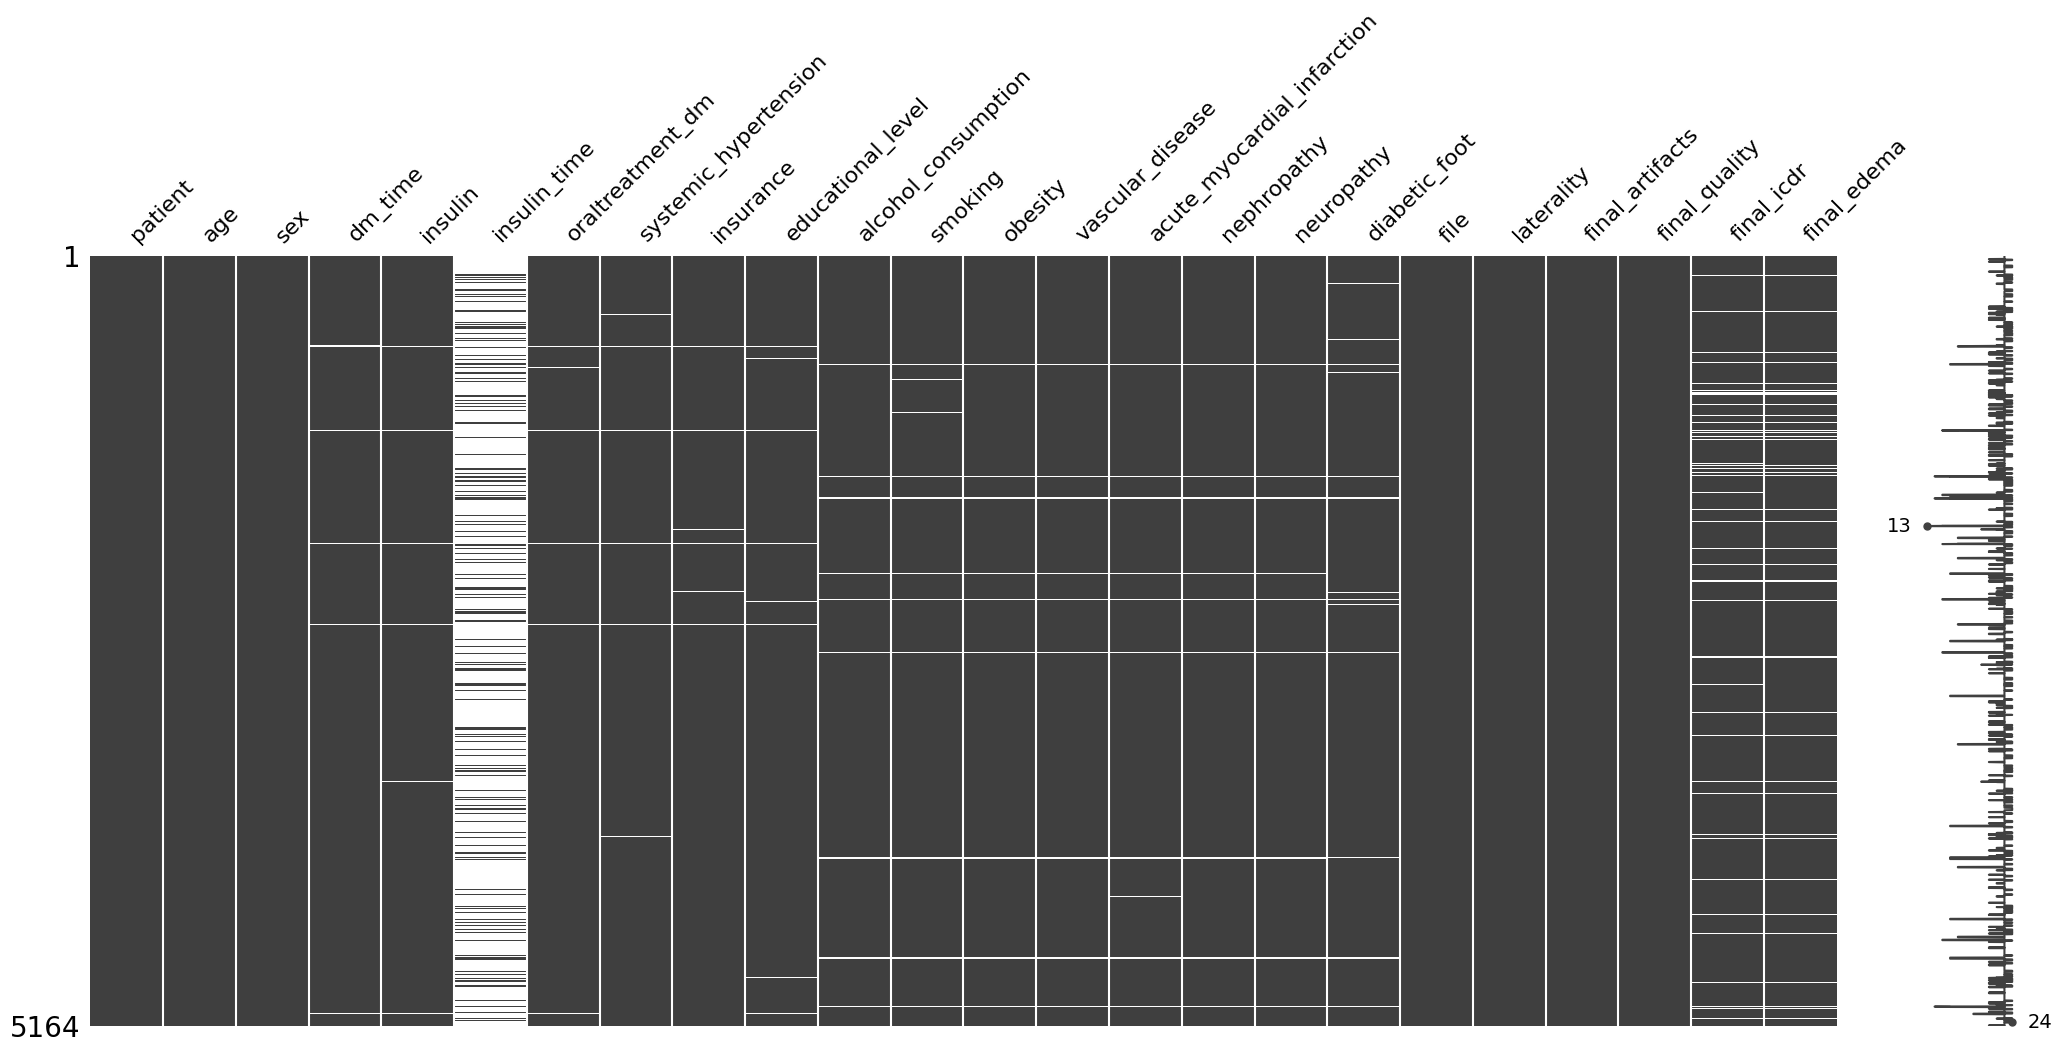

Missing Values per Feature:
 insulin_time                   4148
final_icdr                      280
final_edema                     265
diabetic_foot                   108
smoking                          88
acute_myocardial_infarction      84
nephropathy                      80
vascular_disease                 76
obesity                          76
neuropathy                       76
alcohol_consumption              76
dm_time                          56
educational_level                52
insulin                          48
insurance                        48
oraltreatment_dm                 44
systemic_hypertension            44
dtype: int64


In [3]:
import missingno as msno

# Visualizing missing values
msno.matrix(df)
plt.show()

# Count of missing values per column
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("Missing Values per Feature:\n", missing_counts[missing_counts > 0])

In [4]:
# Check for missing values
print("\n Missing Values Before Imputation:\n", df.isnull().sum())

# Data Preprocessing (Meets Data Cleaning & Feature Engineering Criteria)
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Convert categorical columns to numeric using Label Encoding
if len(categorical_cols) > 0:
    label_enc = LabelEncoder()
    for col in categorical_cols:
        df[col] = label_enc.fit_transform(df[col].astype(str))

# Replace NaN values with column mean (for numeric columns only)
# Use SimpleImputer to handle missing values, it helps ensure the dataset remains usable for ML models but also helps to minimize bias.
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Verify missing values are handled
print("\n Missing Values After Imputation:\n", df.isnull().sum())

# Convert Target Variable to Discrete Labels (Fixes Issue of Continuous Values)
df['final_icdr'] = pd.cut(df['final_icdr'], bins=[-1, 1, 3, 5], labels=[0, 1, 2])

# Verify unique target classes
print("\n Unique Target Classes:", df['final_icdr'].unique())


 Missing Values Before Imputation:
 patient                           0
age                               0
sex                               0
dm_time                          56
insulin                          48
insulin_time                   4148
oraltreatment_dm                 44
systemic_hypertension            44
insurance                        48
educational_level                52
alcohol_consumption              76
smoking                          88
obesity                          76
vascular_disease                 76
acute_myocardial_infarction      84
nephropathy                      80
neuropathy                       76
diabetic_foot                   108
file                              0
laterality                        0
final_artifacts                   0
final_quality                     0
final_icdr                      280
final_edema                     265
dtype: int64

 Missing Values After Imputation:
 patient                        0
age              

## Data Cleaning Summary
The dataset had missing values in features like insulin_time, so I used SimpleImputer to handle missing values. It helps ensure the dataset remains usable for ML models but also helps to minimize bias. It also had some invalid final_icdr values so I cleaned that up as well.

#Exploratory Data Analysis (EDA)

category


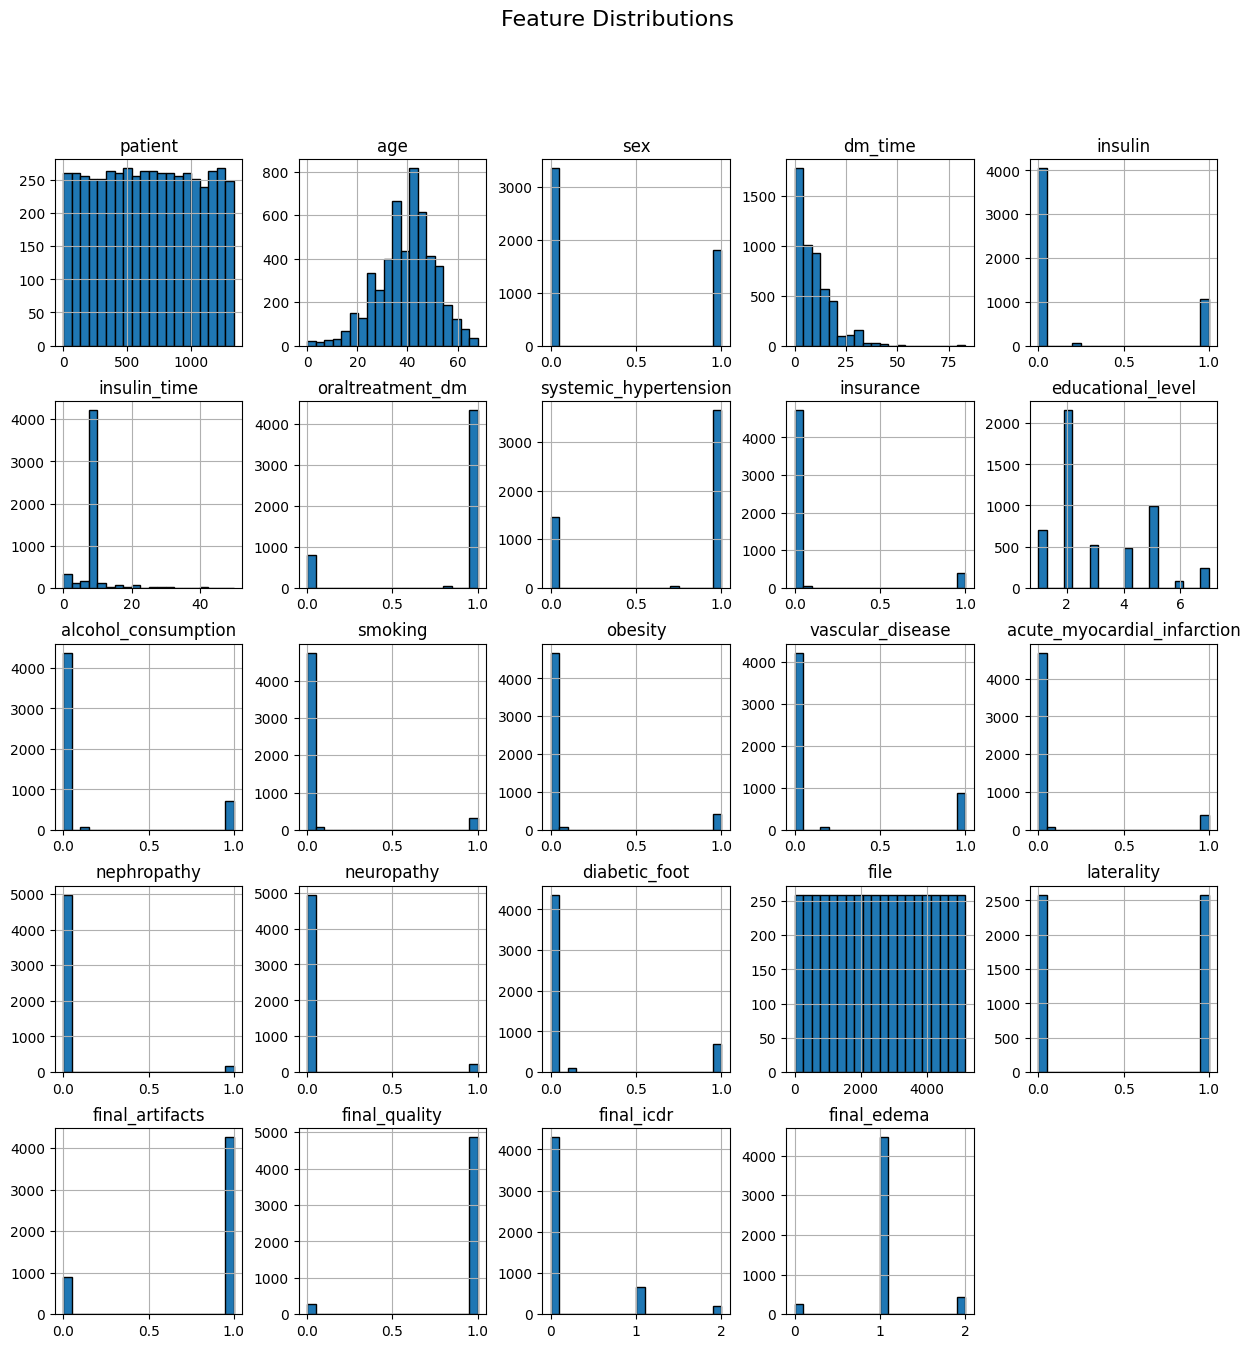

In [5]:
# Histogram of features
print(df['final_icdr'].dtype)
#convert final_icdr to numeric for histogram
df['final_icdr'] = pd.to_numeric(df['final_icdr'], errors='coerce')

df.hist(figsize=(15, 15), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Analysis Using Unsupervised Learning

#Apply PCA

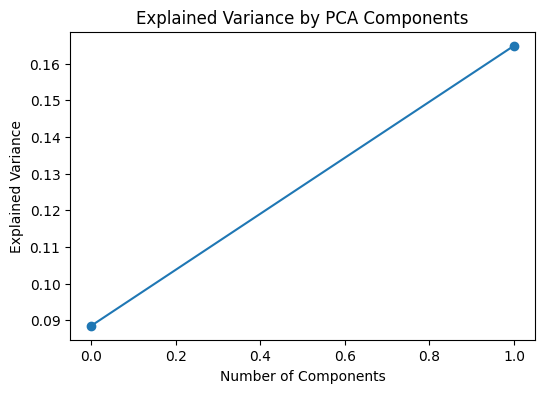

In [6]:
# Standardize numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_cols])

# Apply PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Plot explained variance
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.show()

# Determine the optimal number of clusters using Elbow Method

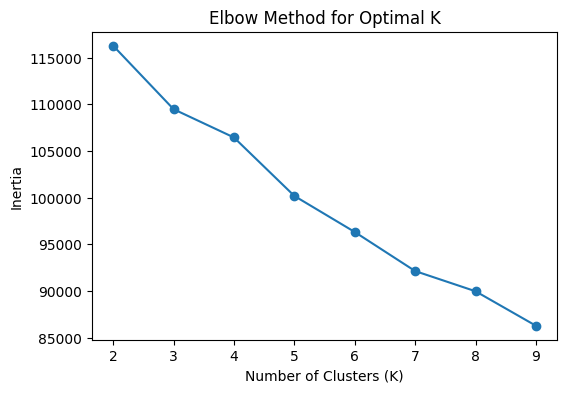

In [7]:
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(6,4))
plt.plot(k_values, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# Apply K-Means Clustering

In [8]:
optimal_k = 3  # Assume elbow occurs at K=3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["KMeans_Cluster"] = kmeans.fit_predict(df_scaled)

# Visualize K-Means Clusters in PCA space

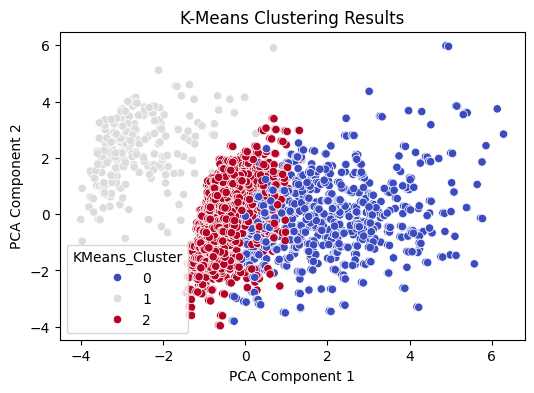

In [9]:

plt.figure(figsize=(6,4))
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue=df["KMeans_Cluster"], palette="coolwarm")
plt.title("K-Means Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

#Dendogram

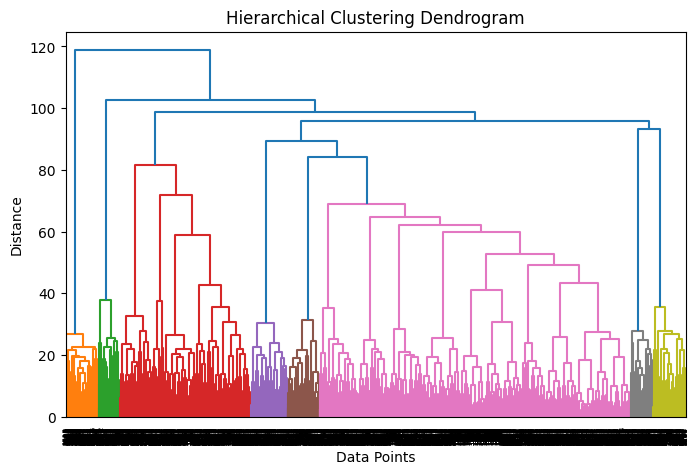

In [10]:
# Generate linkage matrix for dendrogram
linked = linkage(df_scaled, method='ward')

# Plot Dendrogram
plt.figure(figsize=(8,5))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Apply Hierarchical Clustering

In [11]:
hierarchical = AgglomerativeClustering(n_clusters=3)
df["Hierarchical_Cluster"] = hierarchical.fit_predict(df_scaled)

# Visualize Hierarchical Clustering

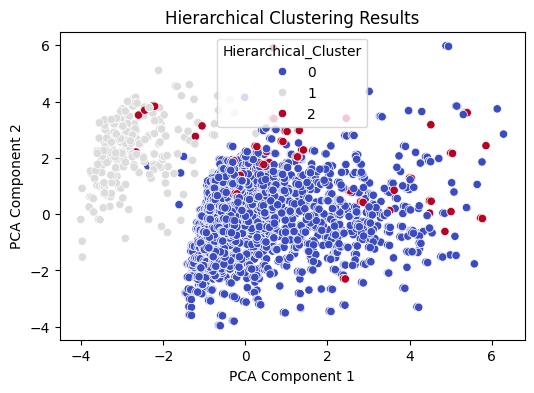

In [12]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue=df["Hierarchical_Cluster"], palette="coolwarm")
plt.title("Hierarchical Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Display cluster distributions


In [13]:
print("\nCluster Distribution (K-Means):\n", df["KMeans_Cluster"].value_counts())
print("\nCluster Distribution (Hierarchical):\n", df["Hierarchical_Cluster"].value_counts())


Cluster Distribution (K-Means):
 KMeans_Cluster
2    3599
0    1274
1     291
Name: count, dtype: int64

Cluster Distribution (Hierarchical):
 Hierarchical_Cluster
0    4709
1     275
2     180
Name: count, dtype: int64


# Discussion
## Analysis of Clustering Results & PCA Comparison


### Key Observations from Clustering
#### K-Means Clustering Distribution:
- **Cluster 2:** 3,599 samples
- **Cluster 0:** 1,274 samples
- **Cluster 1:** 291 samples

#### Hierarchical Clustering Distribution:
- **Cluster 0:** 4,709 samples
- **Cluster 1:** 275 samples
- **Cluster 2:** 180 samples

#### Interpretation:
- Both clustering techniques split the data into three groups, but the sizes differ between K-Means and Hierarchical clustering.
- Cluster 2 in K-Means (3,599 samples) vs. Cluster 0 in Hierarchical (4,709 samples) suggests that one large group is consistently formed across methods.
- Cluster 1 in K-Means (291 samples) vs. Cluster 1 in Hierarchical (275 samples) suggests a small, distinct subgroup.
- The differences in distribution suggest that K-Means and Hierarchical clustering identified different subgroups within the dataset.

### PCA Comparison
#### Explained Variance:
- PCA was applied to reduce dimensionality to 2 components.
- The explained variance plot showed how much information each component retains.

#### Comparison to Clustering:
| **Aspect**            | **PCA**                                 | **Clustering (K-Means & Hierarchical)**  |
|----------------------|--------------------------------------|----------------------------------------|
| **Purpose**         | Reduce high-dimensional data while preserving variance | Group patients into similar categories |
| **Output**          | Two continuous variables (PCA1, PCA2) | Discrete cluster labels |
| **Interpretability** | More abstract, but useful for visualizing high-dimensional data | Easier to understand – clear groups |
| **Effect on Data**  | Preserves relationships between variables | Forces data into distinct clusters |
| **Visualization**   | PCA plot shows variance & patterns | Clustering identifies patient subgroups |


# Conclusion & Future Work

###Conclusion
In this project I used unsupervised learning techniques to identify patterns in diabetic retinopathy patient data using K-Means and Hierarchical Clustering, combined with Principal Component Analysis (PCA) for dimensionality reduction.

Below are some of my key findings:

- For both clustering techniques the dataset was segmented into three distinct patient groups, but the distribution of clusters still varied.

- PCA aided in visualizing high-dimensional data and made it easier to interpret clustering results.

- Hierarchical clustering formed larger clusters, while on the other hand, K-Means had a more balanced distribution across groups.

Even though there is still potential room for improvement, I believe these insights can still be valuable in early identification of high-risk diabetic retinopathy patients, promoting better-targeted interventions and patient monitoring.

### Future Work

As I mentioned in the conclusion, I believe the results provided valuable insights, but I wanted to highlight some areas for improvement and potential further work that remains:

1. Exploring additional clustering methods could help enchance model robustness:

- One example would be to implement DBSCAN to detect potential outliers and more naturally shaped clusters.

- Another could be applying Gaussian Mixture Models to allow for probabilistic cluster assignments instead of hard assignments.

2. Applying feature engineering & selection to more accuretly represent patient groups.

- One option is to perform more domain-specific feature selection to help identify which attributes contribute most to diabetic retinopathy.

- A second option could be to investigate non-linear transformations of features to improve separability of clustering.

3. Incorporating semi-supervised learning to help close the gap between clustering and classification

- This class and project focused on unsupervised learning, but since diabetic retinopathy has labeled severity stages, a hybrid approach such as semi-supervised learning with pseudo-labeling could improve classifying patient risk.

4. Potential real-world applications and model deployment

- The first potential real world application could be to integrate clustering results into a clinical decision-support system which would assist physicians in identify high-risk patients earlier.

- Another potential application would be be to assess how well clusters align with actual patient outcomes using follow up medical records.

By addressing these areas for potential improvement, this project could evolve into a more robust and legitement tool for early diabetic retinopathy detection and management, whcih would ultimately improve decision making in healthcare.


